# 数据预处理与传统机器学习方法
这一部分给出机器学习分类任务的数据预处理。我们使用`tensorflow`加载对应的数据集，使用主成分分析`PCA`，特征检测算法`HOG`和局部特征表述子`Daisy`进行数据预处理。

在后面的笔记本中，我们将使用不同的传统机器学习方法针对预处理得到的数据集进行测试。我们使用了大约十种传统的机器学习方法，包括高斯贝叶斯方法，伯努利贝叶斯方法，支持向量机(`SVM`)、线性支持向量机(`Linear SVM`)、`KNN`、随机森林、逻辑斯蒂回归、决策树、`XGBoost`和`AdaBoost`。

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import tensorflow.keras.datasets as datasets

from sklearn.decomposition import PCA

from sklearn import naive_bayes
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn import svm
from sklearn import tree

import xgboost
from sklearn import ensemble

from skimage.feature import hog
from skimage.feature import daisy

## 数据集加载

In [2]:
# 加载CIFAR-10数据集
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

170498071/170498071 [==============================] - 11s 0us/step


## 数据集分析

In [ ]:
x_train.shape

(50000, 32, 32, 3)

In [ ]:
x_test.shape

(10000, 32, 32, 3)

In [ ]:
x_test.shape

(10000, 3072)

In [ ]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

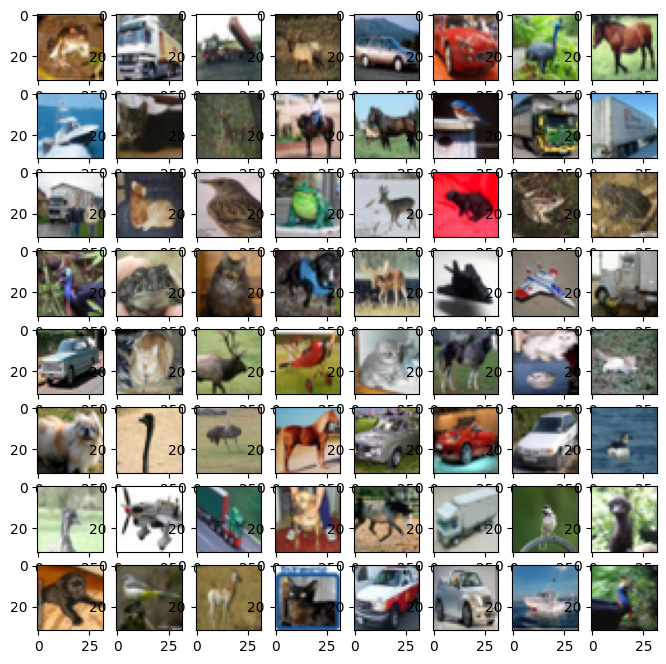

In [3]:
# plotting first 64 images
fig = plt.figure(figsize=(8,8))

for i in range(64):
    ax = fig.add_subplot(8, 8, i+1)
    ax.imshow(x_train[i], cmap = plt.cm.bone)
plt.show()

## 使用PCA进行主成分分析的特征提取

In [4]:
x_train_pca = x_train.reshape(x_train.shape[0],-1)
x_test_pca = x_test.reshape(x_test.shape[0],-1)

In [5]:
pca = PCA()
pca.fit_transform(x_train_pca)

array([[-1.63225950e+03,  6.95904885e+02,  3.82936183e+02, ...,
        -1.94383396e-01, -2.96716275e-01, -8.91909421e-02],
       [ 2.11594763e+02, -2.42235521e+02,  1.53095691e+03, ...,
         2.76508201e-02,  1.47062424e-01, -1.96606511e-01],
       [ 1.97120094e+03, -2.93813609e+03, -7.02173229e+02, ...,
        -2.66373278e-01, -5.45969636e-02, -1.00334729e-01],
       ...,
       [ 1.80373380e+02, -2.89234292e+03, -1.00448294e+02, ...,
        -9.69870999e-02,  4.75402487e-01,  3.69202335e-01],
       [ 2.89881680e+03, -8.60874301e+02,  1.41938040e+03, ...,
        -1.19109692e-01,  1.89968105e-01, -4.26015893e-01],
       [ 1.06916310e+03, -3.01968063e+02, -1.13372056e+03, ...,
         2.46831906e-01,  6.12928127e-02, -7.15290870e-03]])

In [6]:
pca.explained_variance_.shape

(3072,)

### 计算保留的$k$个主成分
这里方差达到95%即可不找。

In [7]:
k = 0
total = sum(pca.explained_variance_)
current_sum = 0

while(current_sum / total < 0.99):
    current_sum += pca.explained_variance_[k]
    k += 1
k

658

### 进行主成分分析
根据上面得到的主成分个数进行主成分分析

In [8]:
pca = PCA(n_components=k, whiten=True)

x_train_pca = pca.fit_transform(x_train_pca)
x_test_pca = pca.transform(x_test_pca)

In [10]:
print(x_train_pca.shape)
print(x_test_pca.shape)

(50000, 658)
(10000, 658)


## 使用Hog算法进行特征提取

In [30]:
def rgb2gray(im):
    gray = im[:, :, 0]*0.2989+im[:, :, 1]*0.5870+im[:, :, 2]*0.1140
    return gray

def getFeat_Hog(TrainData,TestData):
    train_feature=np.zeros(shape=(50000,324))
    test_feature=np.zeros(shape=(10000,324))
    cnt=0
    for data in TrainData:
        image = data
        gray = rgb2gray(image)/255.0
        fd = hog(gray, orientations=9, pixels_per_cell=(8,8), cells_per_block=(3,3))

        train_feature[cnt] = fd
        cnt = cnt + 1

    print("Train features are extracted and saved.")
    cnt=0
    for data in TestData:
        image = data
        gray = rgb2gray(image)/255.0
        fd = hog(gray, orientations=9, pixels_per_cell=(8,8), cells_per_block=(3,3))

        test_feature[cnt]=fd
        cnt=cnt+1

    print("Test features are extracted and saved.")
    return train_feature,test_feature

In [38]:
x_train_hog,x_test_hog = getFeat_Hog(x_train, x_test)

Train features are extracted and saved.
Test features are extracted and saved.


## 使用Daisy方法进行特征提取

In [28]:
def getFeat_Daisy(TrainData, TestData):

    train_feature=np.zeros(shape=(50000,200))
    test_feature=np.zeros(shape=(10000,200))
    cnt=0
    for data in TrainData:
        image = data
        gray = rgb2gray(image)/255.0
        fd = daisy(gray)

        train_feature[cnt] = fd
        cnt = cnt + 1

    print("Train features are extracted and saved.")

    cnt=0
    for data in TestData:
        image = data
        gray = rgb2gray(image)/255.0
        fd = daisy(gray)

        test_feature[cnt]=fd
        cnt=cnt+1

    print("Test features are extracted and saved.")


    return train_feature,test_feature

In [31]:
x_train_daisy,x_test_daisy = getFeat_Daisy(x_train, x_test)

Train features are extracted and saved.
Test features are extracted and saved.


## 模型训练
### 训练函数

In [ ]:
def train_model(method,x_train,x_test,y_train,y_test):
    # train
    method.fit(x_train,y_train)
    # predict
    y_pred = method.predict(x_test)
    return accuracy_score(y_test,y_pred)

### 伯努利贝叶斯方法


#### PCA分析

In [ ]:
bernoulli_naive_bayes_score_pca = train_model(naive_bayes.BernoulliNB(),x_train_pca,x_test_pca,y_train,y_test)
bernoulli_naive_bayes_score_pca

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.3296

#### HOG分析

In [ ]:
bernoulli_naive_bayes_score_hog = train_model(naive_bayes.BernoulliNB(),x_train_hog,x_test_hog,y_train,y_test)
bernoulli_naive_bayes_score_hog

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.2216

#### Daisy分析

In [ ]:
bernoulli_naive_bayes_score_daisy = train_model(naive_bayes.BernoulliNB(),x_train_daisy,x_test_daisy,y_train,y_test)
bernoulli_naive_bayes_score_daisy

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.1

### 高斯贝叶斯方法


#### PCA分析

In [ ]:
gaussian_naive_bayes_score_pca = train_model(naive_bayes.GaussianNB(),x_train_pca,x_test_pca,y_train,y_test)
gaussian_naive_bayes_score_pca

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.2917

#### HOG分析

In [ ]:
gaussian_naive_bayes_score_hog = train_model(naive_bayes.GaussianNB(),x_train_hog,x_test_hog,y_train,y_test)
gaussian_naive_bayes_score_hog

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.4537

#### Daisy分析

In [ ]:
gaussian_naive_bayes_score_daisy = train_model(naive_bayes.GaussianNB(),x_train_daisy,x_test_daisy,y_train,y_test)
gaussian_naive_bayes_score_daisy

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.3839

### 随机森林


#### PCA分析

In [ ]:
random_forest_score_pca = train_model(RandomForestClassifier(),x_train_pca,x_test_pca,y_train,y_test)
random_forest_score_pca

<ipython-input-64-e32c56a4d209>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  method.fit(x_train,y_train)


0.3834

#### HOG 分析

In [ ]:
random_forest_score_hog = train_model(RandomForestClassifier(),x_train_hog,x_test_hog,y_train,y_test)
random_forest_score_hog

0.5105

#### Daisy分析

In [ ]:
random_forest_score_daisy = train_model(RandomForestClassifier(),x_train_daisy,x_test_daisy,y_train,y_test)
random_forest_score_daisy

<ipython-input-88-e32c56a4d209>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  method.fit(x_train,y_train)


0.5229

### KNN 方法


#### PCA分析

In [ ]:
knn_score_pca = train_model(KNeighborsClassifier(),x_train_pca,x_test_pca,y_train,y_test)
knn_score_pca

0.1456

#### HOG分析

In [ ]:
knn_score_hog = train_model(KNeighborsClassifier(),x_train_hog,x_test_hog,y_train,y_test)
knn_score_hog

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.5047

#### Daisy分析

In [ ]:
knn_score_daisy = train_model(KNeighborsClassifier(),x_train_daisy,x_test_daisy,y_train,y_test)
knn_score_daisy

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.4859

### 逻辑斯蒂回归


#### PCA分析

In [ ]:
logistic_regression_score_pca = train_model(LogisticRegression(),x_train_pca,x_test_pca,y_train,y_test)
logistic_regression_score_pca

0.4029

#### HOG分析

In [ ]:
logistic_regression_score_hog = train_model(LogisticRegression(),x_train_hog,x_test_hog,y_train,y_test)
logistic_regression_score_hog

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5095

#### Daisy分析

In [ ]:
logistic_regression_score_daisy = train_model(LogisticRegression(),x_train_daisy,x_test_daisy,y_train,y_test)
logistic_regression_score_daisy

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.3604

### 线性SVM

#### PCA分析

In [ ]:
linear_svc_score_pca = train_model(svm.LinearSVC(),x_train_pca,x_test_pca,y_train,y_test)
linear_svc_score_pca

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.3395

#### HOG分析

In [ ]:
linear_svc_score_hog = train_model(svm.LinearSVC(),x_train_hog,x_test_hog,y_train,y_test)
linear_svc_score_hog

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5047

#### Daisy分析

In [ ]:
linear_svc_score_daisy = train_model(svm.LinearSVC(),x_train_daisy,x_test_daisy,y_train,y_test)
linear_svc_score_daisy

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.4117

### SVM


#### PCA分析

In [ ]:
linear_svc_score_pca = train_model(svm.SVC(),x_train_pca,x_test_pca,y_train,y_test)
linear_svc_score_pca

#### HOG分析

In [ ]:
linear_svc_score_hog = train_model(svm.SVC(),x_train_hog,x_test_hog,y_train,y_test)
linear_svc_score_hog

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Daisy分析

In [ ]:
linear_svc_score_daisy = train_model(svm.SVC(),x_train_daisy,x_test_daisy,y_train,y_test)
linear_svc_score_daisy

### 决策树


#### PCA分析

In [ ]:
decision_tree_score_pca = train_model(tree.DecisionTreeClassifier(),x_train_pca,x_test_pca,y_train,y_test)
decision_tree_score_pca

0.2393

#### HOG分析

In [ ]:
decision_tree_score_hog = train_model(tree.DecisionTreeClassifier(),x_train_hog,x_test_hog,y_train,y_test)
decision_tree_score_hog

0.2741

#### Daisy分析

In [ ]:
decision_tree_score_daisy = train_model(tree.DecisionTreeClassifier(),x_train_daisy,x_test_daisy,y_train,y_test)
decision_tree_score_daisy

0.3123

### XGBoost


#### PCA分析

In [ ]:
XGBoost_score_pca = train_model(xgboost.XGBClassifier(),x_train_pca,x_test_pca,y_train,y_test)
XGBoost_score_pca

0.4939

#### HOG分析

In [ ]:
XGBoost_score_hog = train_model(xgboost.XGBClassifier(),x_train_hog,x_test_hog,y_train,y_test)
XGBoost_score_hog

0.5826

#### Daisy分析

In [ ]:
XGBoost_score_daisy = train_model(xgboost.XGBClassifier(),x_train_daisy,x_test_daisy,y_train,y_test)
XGBoost_score_daisy

0.6049

### AdaBoost


#### PCA分析

In [ ]:
AdaBoost_score_pca = train_model(ensemble.AdaBoostClassifier(),x_train_pca,x_test_pca,y_train,y_test)
AdaBoost_score_pca

0.3419

#### HOG分析

In [ ]:
AdaBoost_score_hog = train_model(ensemble.AdaBoostClassifier(),x_train_hog,x_test_hog,y_train,y_test)
AdaBoost_score_hog

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.378

#### Daisy分析

In [ ]:
AdaBoost_score_daisy = train_model(ensemble.AdaBoostClassifier(),x_train_daisy,x_test_daisy,y_train,y_test)
AdaBoost_score_daisy

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.3648

### 决策树 调参


#### PCA

In [22]:
def accs(x_train,x_test,y_train,y_test):
    accuracies = []
    for i in range(20):
        clf = tree.DecisionTreeClassifier(max_depth=i+1, min_samples_split=4)
        clf.fit(x_train,y_train)
        y_pred = clf.predict(x_test)
        acc = accuracy_score(y_test,y_pred)
        accuracies.append(acc)
        print(i,acc)
    return accuracies

In [24]:
pca_dec_acc = accs(x_train_pca,x_test_pca,y_train,y_test)

0 0.1468
1 0.2013
2 0.2274
3 0.2395
4 0.2552
5 0.2729
6 0.2942
7 0.3072
8 0.3116
9 0.307
10 0.3045
11 0.2988
12 0.2952
13 0.2838
14 0.2787
15 0.2723
16 0.2698
17 0.268
18 0.2602
19 0.2552


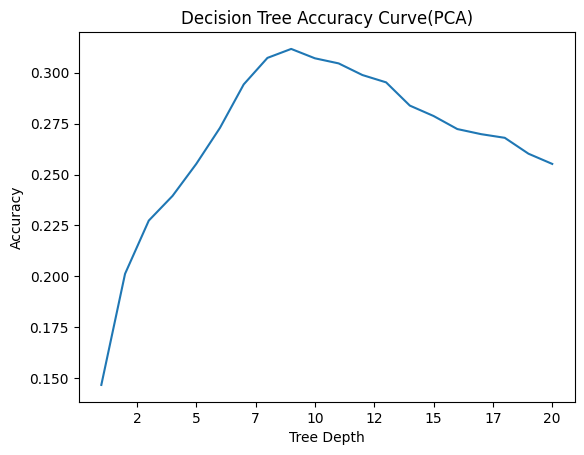

In [37]:
x = range(1,21)
plt.gca().xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
plt.plot(x, pca_dec_acc)

plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Accuracy Curve(PCA)')

plt.show()

#### Hog

In [39]:
hog_dec_acc = accs(x_train_hog,x_test_hog,y_train,y_test)

0 0.1453
1 0.1712
2 0.21
3 0.2447
4 0.2595
5 0.2759
6 0.284
7 0.2907
8 0.2981
9 0.298
10 0.2982
11 0.3019
12 0.297
13 0.2971
14 0.2928
15 0.291
16 0.2857
17 0.2858
18 0.2809
19 0.2788


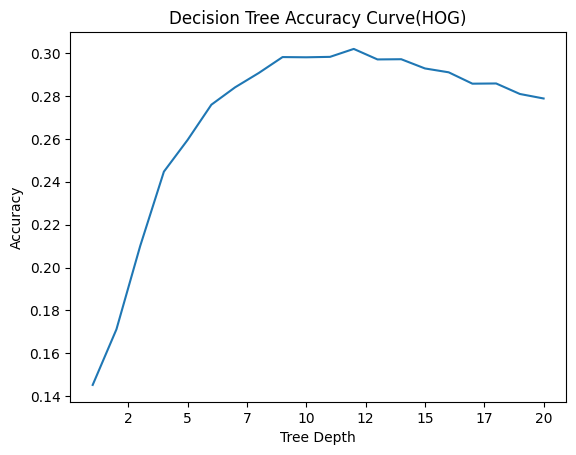

In [40]:
x = range(1,21)
plt.plot(x, hog_dec_acc)

plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.gca().xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
plt.title('Decision Tree Accuracy Curve(HOG)')

plt.show()

#### Daisy

In [32]:
daisy_dec_acc = accs(x_train_daisy,x_test_daisy,y_train,y_test)

0 0.1528
1 0.2058
2 0.2442
3 0.2675
4 0.2852
5 0.2999
6 0.3185
7 0.3315
8 0.3412
9 0.3423
10 0.3448
11 0.3457
12 0.3372
13 0.3357
14 0.3316
15 0.3268
16 0.3242
17 0.3223
18 0.3204
19 0.3142


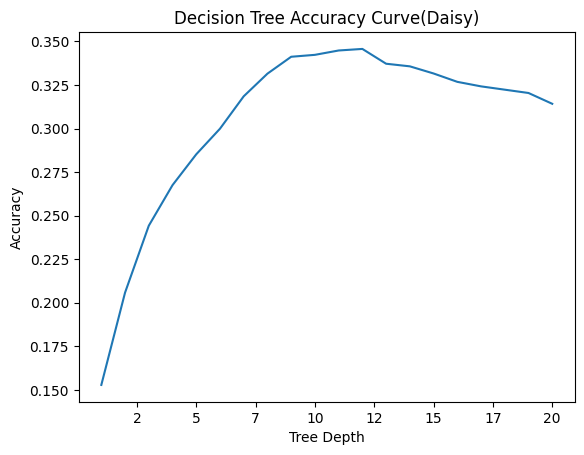

In [36]:
x = range(1,21)
plt.plot(x, daisy_dec_acc)

plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.gca().xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
plt.title('Decision Tree Accuracy Curve(Daisy)')

plt.show()

### KNN 调参

In [46]:
def KNNs(x_train,x_test,y_train,y_test):
    accuracies = []
    for i in range(20):
        clf = KNeighborsClassifier(n_neighbors=i+1, weights='uniform')
        clf.fit(x_train,y_train)
        y_pred = clf.predict(x_test)
        acc = accuracy_score(y_test,y_pred)
        accuracies.append(acc)
        print(i,acc)
    return accuracies

#### PCA

In [51]:
pca_knn_acc = KNNs(x_train_pca,x_test_pca,y_train,y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0 0.1721


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


1 0.1744


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


2 0.1451


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


3 0.1474


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


4 0.1423


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


5 0.1375


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


6 0.1383


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


7 0.1348


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


8 0.1308


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


9 0.1281


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


10 0.1254


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


11 0.1218


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


12 0.1202


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


13 0.1182


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


14 0.1176


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


15 0.1177


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


16 0.1167


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


17 0.1154


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


18 0.1154


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


19 0.113


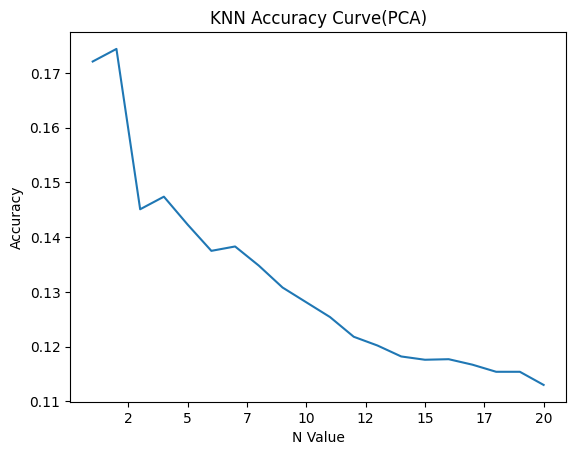

In [52]:
x = range(1,21)
plt.plot(x, pca_knn_acc)

plt.xlabel('N Value')
plt.ylabel('Accuracy')
plt.gca().xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
plt.title('KNN Accuracy Curve(PCA)')

plt.show()

#### Hog

In [47]:
hog_knn_acc = KNNs(x_train_hog,x_test_hog,y_train,y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0 0.4802


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


1 0.4558


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


2 0.4868


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


3 0.4959


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


4 0.5047


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


5 0.5126


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


6 0.518


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


7 0.5206


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


8 0.5229


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


9 0.5259


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


10 0.5253


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


11 0.528


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


12 0.531


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


13 0.5281


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


14 0.5308


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


15 0.5271


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


16 0.5265


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


17 0.5215


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


18 0.5227


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


19 0.5209


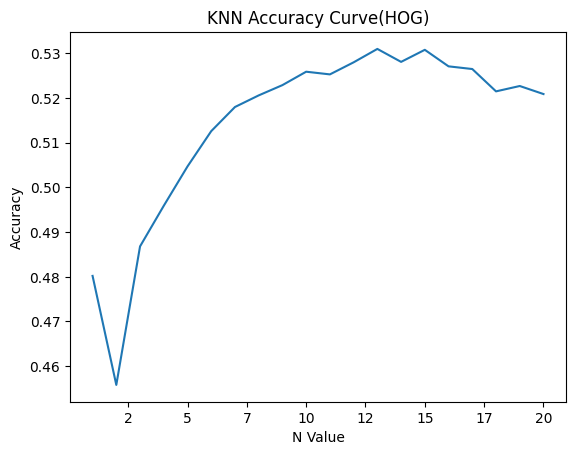

In [48]:
x = range(1,21)
plt.plot(x, hog_knn_acc)

plt.xlabel('N Value')
plt.ylabel('Accuracy')
plt.gca().xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
plt.title('KNN Accuracy Curve(HOG)')

plt.show()

#### Daisy

In [49]:
daisy_knn_acc = KNNs(x_train_daisy,x_test_daisy,y_train,y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0 0.4734


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


1 0.4499


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


2 0.4767


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


3 0.4845


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


4 0.4859


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


5 0.4857


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


6 0.4862


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


7 0.4869


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


8 0.4877


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


9 0.4872


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


10 0.4834


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


11 0.485


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


12 0.4825


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


13 0.4832


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


14 0.4809


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


15 0.4822


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


16 0.4794


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


17 0.4781


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


18 0.476


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


19 0.4742


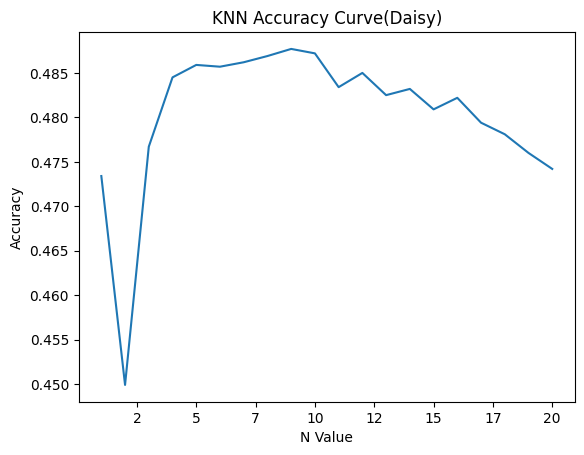

In [50]:
x = range(1,21)
plt.plot(x, daisy_knn_acc)

plt.xlabel('N Value')
plt.ylabel('Accuracy')
plt.gca().xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
plt.title('KNN Accuracy Curve(Daisy)')

plt.show()

### 随机森林 调参

In [54]:
def RFs(x_train,x_test,y_train,y_test):
    accuracies = []
    for i in range(20):
        clf = RandomForestClassifier(max_depth=i+1)
        clf.fit(x_train,y_train)
        y_pred = clf.predict(x_test)
        acc = accuracy_score(y_test,y_pred)
        accuracies.append(acc)
        print(i,acc)
    return accuracies

#### PCA

In [55]:
pca_RF_acc = RFs(x_train_pca,x_test_pca,y_train,y_test)

<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


0 0.2889


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


1 0.3146


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


2 0.3376


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


3 0.3552


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


4 0.376


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


5 0.3915


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


6 0.3959


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


7 0.4077


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


8 0.408


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


9 0.4114


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


10 0.4207


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


11 0.4157


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


12 0.415


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


13 0.4198


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


14 0.4143


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


15 0.4145


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


16 0.4162


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


17 0.4083


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


18 0.4066


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


19 0.4075


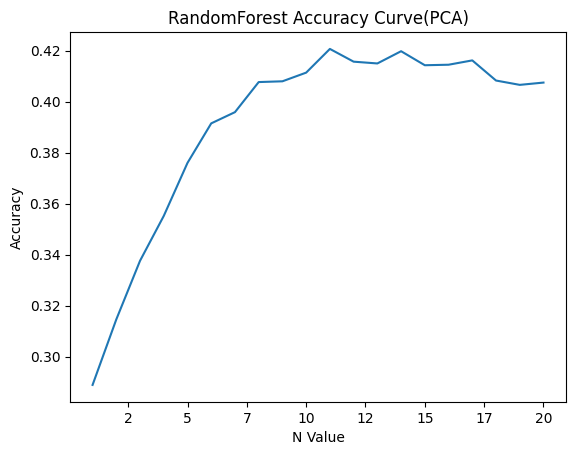

In [56]:
x = range(1,21)
plt.plot(x, pca_RF_acc)

plt.xlabel('N Value')
plt.ylabel('Accuracy')
plt.gca().xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
plt.title('RandomForest Accuracy Curve(PCA)')

plt.show()

#### Hog

In [57]:
hog_RF_acc = RFs(x_train_hog,x_test_hog,y_train,y_test)

<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


0 0.1993


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


1 0.2727


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


2 0.3053


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


3 0.3444


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


4 0.3801


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


5 0.4041


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


6 0.422


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


7 0.4433


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


8 0.4542


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


9 0.4697


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


10 0.4798


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


11 0.4839


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


12 0.4953


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


13 0.4979


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


14 0.5022


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


15 0.5045


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


16 0.5053


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


17 0.5025


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


18 0.5062


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


19 0.5096


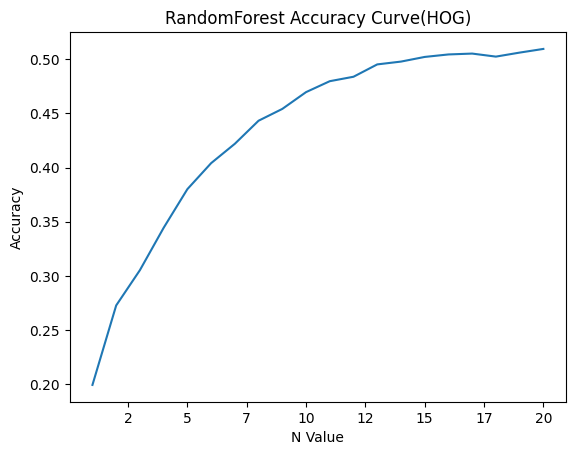

In [58]:
x = range(1,21)
plt.plot(x, hog_RF_acc)

plt.xlabel('N Value')
plt.ylabel('Accuracy')
plt.gca().xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
plt.title('RandomForest Accuracy Curve(HOG)')

plt.show()

#### Daisy

In [59]:
daisy_RF_acc = RFs(x_train_daisy,x_test_daisy,y_train,y_test)

<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


0 0.2395


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


1 0.2913


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


2 0.3292


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


3 0.3508


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


4 0.3757


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


5 0.3949


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


6 0.4106


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


7 0.4311


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


8 0.4448


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


9 0.4624


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


10 0.4742


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


11 0.4844


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


12 0.4957


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


13 0.503


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


14 0.5041


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


15 0.5099


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


16 0.5135


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


17 0.5209


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


18 0.5235


<ipython-input-54-fd7b4051059d>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train,y_train)


19 0.5192


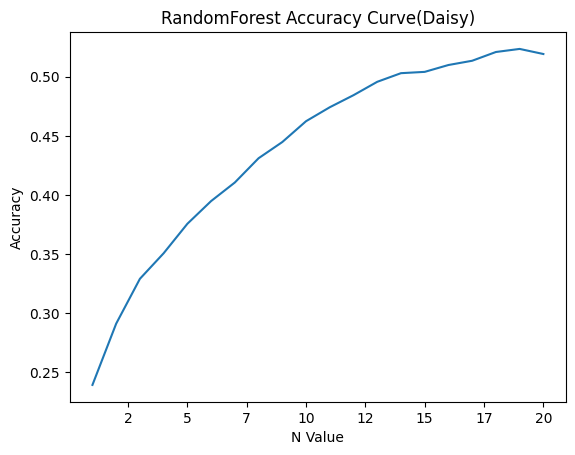

In [60]:
x = range(1,21)
plt.plot(x, daisy_RF_acc)

plt.xlabel('N Value')
plt.ylabel('Accuracy')
plt.gca().xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
plt.title('RandomForest Accuracy Curve(Daisy)')

plt.show()